# Latent Space Approaches to Social Network Analysis

## Introduction

In the study of historical social networks, the relationships between influential families provide valuable insights into power dynamics, alliances, and social structures. One such case is the analysis conducted by Padgett and Ansell (1993), which examines marriage and business ties among 16 historically prominent Florentine families during the 15th century. Their work is based on historical accounts, particularly the research of Kent (1978), which documents the socio-political landscape of Renaissance Florence.

This notebook focuses specifically on the marriage relations between these families. In this dataset, a tie exists between two families if at least one marriage occurred between them. The relationship is undirected, as the records do not specify the respective families of the husband and wife. Notably, one of the 16 families had no marriage ties to others and was consequently excluded from the analysis. Including this family would result in an infinite distance in a maximum likelihood estimation and a large but finite distance in a Bayesian framework. By modeling these marriage relations using network analysis techniques, we can explore the structural properties of the Florentine elite and their strategic matrimonial alliances. This analysis provides a deeper understanding of the role of marriage in shaping political and economic power during the Renaissance. This work is inspired and replicated according the article of Hoff 2002 (consult [1]).

We are going to use the following libraries:

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

## Florentine Families Network

The graph of the Florentine families is presented in the following plot.

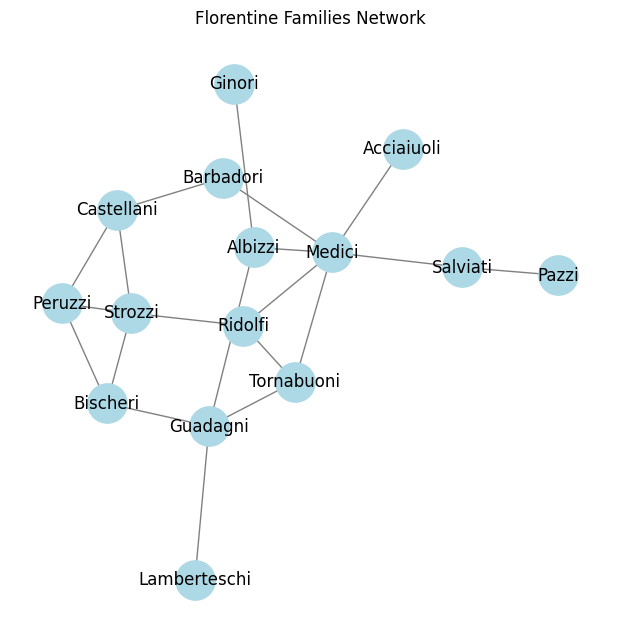

In [3]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()


It is important to reindex with integer number the previous network in order to deal with nodes and edges easily.

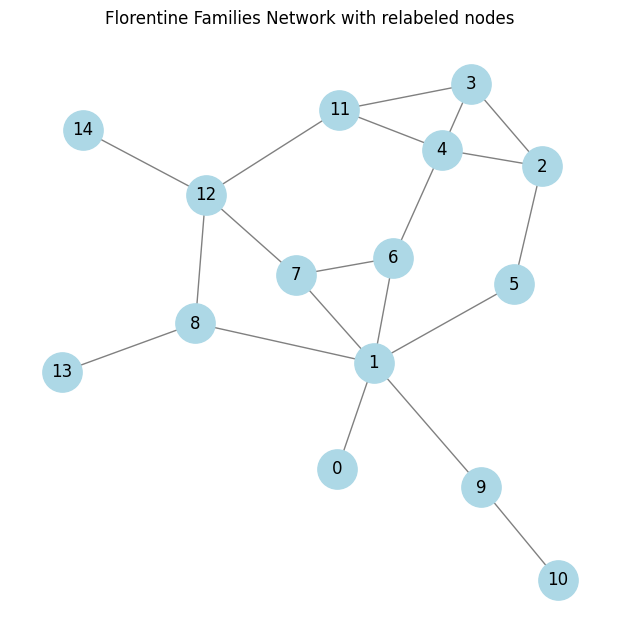

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [4]:
G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

The sociomatrix $Y$ or adjacency matrix is calculated in the following code.

In [5]:
nx.to_numpy_array(G, dtype=int)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

<Axes: >

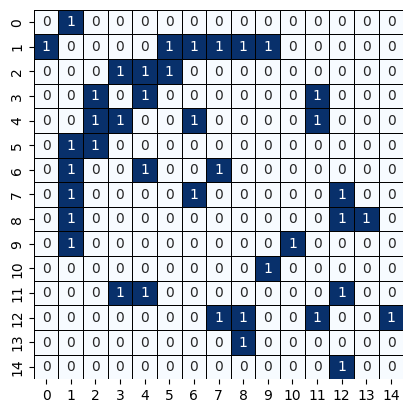

In [6]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=True, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='black')

## Latent Space

To start the latent space model, the number of nodes $n$ in the graph is calculated and the latent variables are randomly initialized with sampling from a normal standard distribution a matrix of size $n\times 2$ since we are representing our network in a $2$-dimensional space.

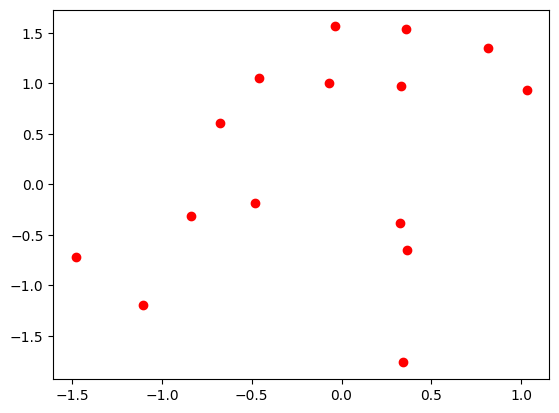

In [7]:
n = len(G.nodes)

Z = np.random.randn(n, 2)
plt.plot(Z[:,0],Z[:,1], 'ro')
plt.show()

## Likelihood

In order to calculate the probability to have a tie between two nodes given the latent variables and its properties, the following model is proposed:


$$\eta_{ij} := logit(\mathbb{P}(y_{ij}=1\ |\ z_i,z_j,a)) = a (1-d_{ij}),$$

equivalently,

$$\mu_{ij} := \mathbb{P}(y_{ij}=1\ |\ z_i,z_j,a) = expit(a (1-d_{ij})) = \frac{1}{1+\exp{(-a(1-d_{ij}))}},$$

where $d_{ij}$ measures the distance between the two latent variables in the next way,

$$d_{ij} = \frac{1}{2}\|z_i-z_j\|^2.$$

Since $y_{ij}\in\{0,1\}$ and we suppose that the conection bewteen edges are independente, then the likelihood is given by the expression

$$L(\eta) = \mathbb{P}(Y\ |\ \eta) = \prod_{i\not=j} \mu_{ij}^{y_{ij}}(1-\mu_{ij})^{1-y_{ij}},$$


and the log-likelihood

$$\ell(\eta) = \log(\mathbb{P}(Y\ |\ \eta)) = \sum_{i\not=j} \eta_{ij}y_{ij} - \log(1+e^{\eta_{ij}}),$$

with its respective derivatives,


$$\frac{\partial}{\partial z_{k}} \ell(\eta) = \sum_{i\not=k} a (z_k-z_i)\left(expit(\eta_{ki})- y_{ki}\right),$$

$$\frac{\partial}{\partial a} \ell(\eta) =  \sum_{i\not=j} -(1-d_{ij})\left(expit(\eta_{ki})- y_{ki}\right).$$

In [8]:
def loglikelihood(Z,a):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            eta = a * ( 1 - 0.05 * np.linalg.norm(Z[i] - Z[j])**2)
            if j in G.neighbors(i):
                total += eta * 1  + (-np.logaddexp(0, eta))
            elif j != i:
                total += (-np.logaddexp(0, eta))
    return total

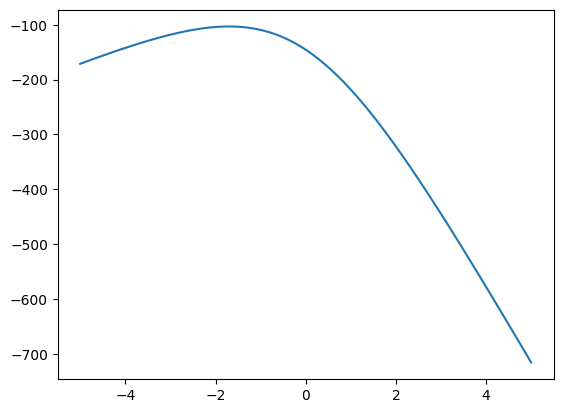

In [9]:
plt.plot(np.linspace(-5,5,100),[loglikelihood(Z,t) for t in np.linspace(-5,5,100)])
plt.show()

In [10]:
def grad_loglikelihood(Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = 0.05 * np.linalg.norm(Z[i] - Z[j])**2
                eta = a* ( 1 - dist )
                grad_Z[i,:] +=  a * (Z[i] - Z[j]) * (expit(eta) - y)
                grad_a += (-1) * (1-dist) * (expit(eta) - y) 
    return grad_Z, grad_a

-151.19426327815108
-135.85586602267637


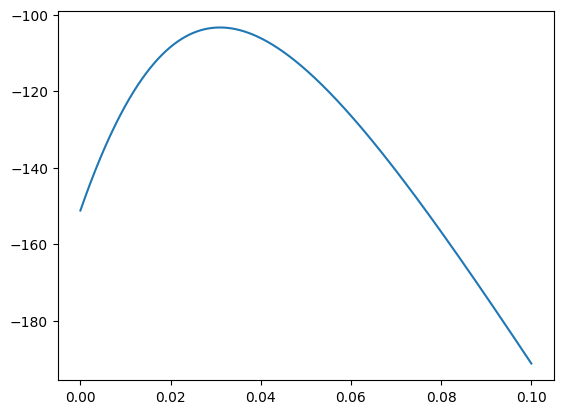

In [11]:
grad_Z,  grad_a = grad_loglikelihood(Z,0.1)
lr = 0.005
print(loglikelihood(Z,0.1))
print(loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

### Searching MLE

For searching the maximum likelihood estimation, we search the maximum of the loglikelihood function through gradient descent with line search.

In [12]:
def SearchingMLE(Z_init, a_init, tol=1e-1, max_iter=1000, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]
    
    for i in range(max_iter):
        grad_Z,  grad_a = grad_loglikelihood(Z0,a0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(Z0 + alpha * grad_Z,a0 + alpha*grad_a) < loglikelihood(Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
            if alpha < 1e-4:
                alpha = 0.0
                break
        
        # Update step
        Z0 = Z0 + alpha * grad_Z  
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)
    
    return  Z0, a0, historyZ, historya

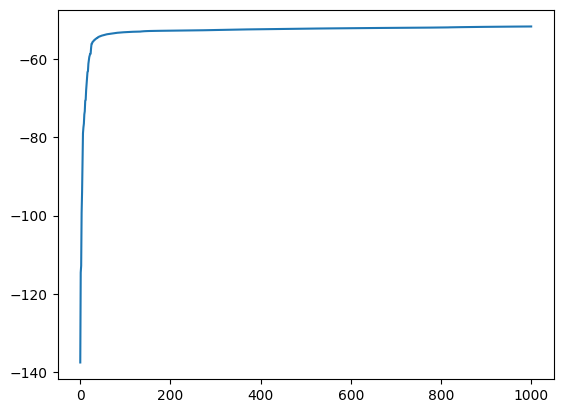

In [13]:
Z0, a0, historyZ, historya  =  SearchingMLE(np.random.randn(n, 2),np.random.randn())
Z0 = Z0 - np.mean(Z0, axis=0)
plt.plot([loglikelihood(historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

In [14]:
print(loglikelihood(Z0,a0))

print(loglikelihood(0.5*Z0,a0))

print(loglikelihood(np.random.randn(n, 2),np.random.randn()))

-51.73302613700928
-283.452005569738
-260.5167737779029


In [15]:
Z0 

array([[-0.27333035,  1.61472356],
       [ 1.62098364, -2.57992933],
       [-2.16281514, -1.5280557 ],
       [ 0.95527124,  1.95137318],
       [ 2.56212572, -0.89501224],
       [ 0.58179935,  1.99069423],
       [-2.41019911, -0.905863  ],
       [ 0.2116914 ,  2.2403716 ],
       [-0.72710239,  2.11533364],
       [ 0.01999225,  2.05724134],
       [ 0.26039913, -1.9950137 ],
       [-2.47171702, -0.93512646],
       [ 2.01425378, -1.90334631],
       [ 1.25198271, -1.79541247],
       [-1.43333523,  0.56802166]])

In [16]:
Z0.T @ Z0

array([[35.43486081, -4.53263559],
       [-4.53263559, 46.74024337]])

In [17]:
U, S, _ = np.linalg.svd(Z0.T @ Z0)

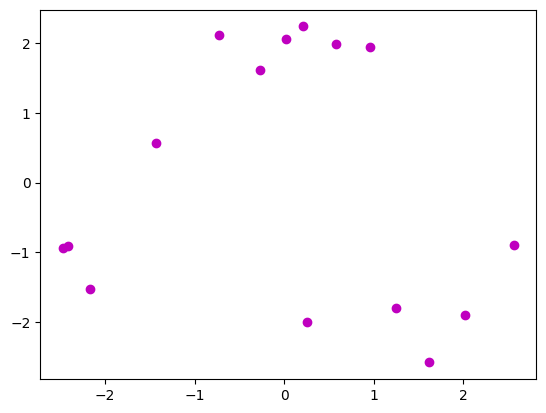

In [18]:
plt.plot(Z0[:,0],Z0[:,1], 'mo')
plt.show()

### Sociomatrix

In [19]:
Z0

array([[-0.27333035,  1.61472356],
       [ 1.62098364, -2.57992933],
       [-2.16281514, -1.5280557 ],
       [ 0.95527124,  1.95137318],
       [ 2.56212572, -0.89501224],
       [ 0.58179935,  1.99069423],
       [-2.41019911, -0.905863  ],
       [ 0.2116914 ,  2.2403716 ],
       [-0.72710239,  2.11533364],
       [ 0.01999225,  2.05724134],
       [ 0.26039913, -1.9950137 ],
       [-2.47171702, -0.93512646],
       [ 2.01425378, -1.90334631],
       [ 1.25198271, -1.79541247],
       [-1.43333523,  0.56802166]])

In [20]:
a0

np.float64(-9.605177010450596)

In [21]:
Y = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y[i,j] = expit(a0 * (1 - 0.05 * np.linalg.norm(Z0[i] - Z0[j])**2))

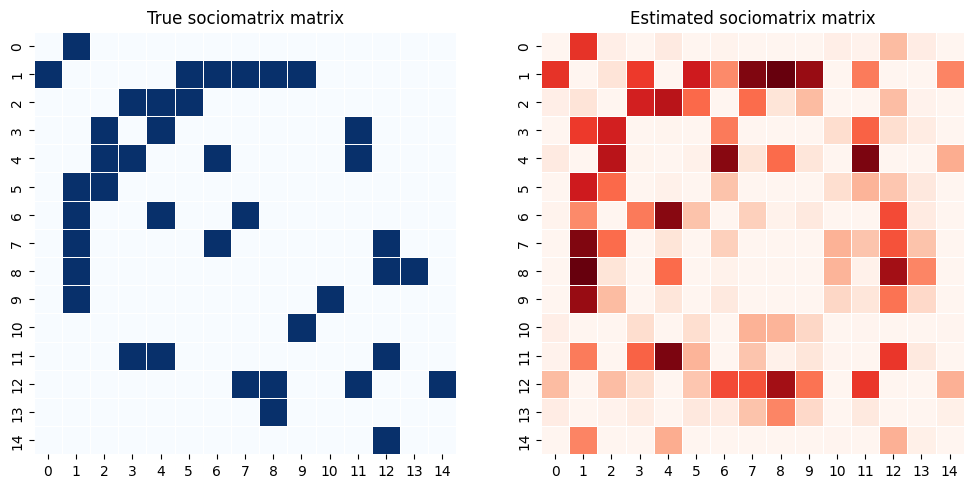

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

## Prior distribution

In [23]:
def logpriori(Z,a,var=10):
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + 0.5 * np.sum(Z**2)/var + 0.5 * a**2 / var)

In [24]:
def grad_logpriori(Z,a,var=10):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = (-1) * Z[i,:] / var
    grad_a = (-1) * a / var  
    return grad_Z, grad_a

-34.32724065386913
-33.12369727522713


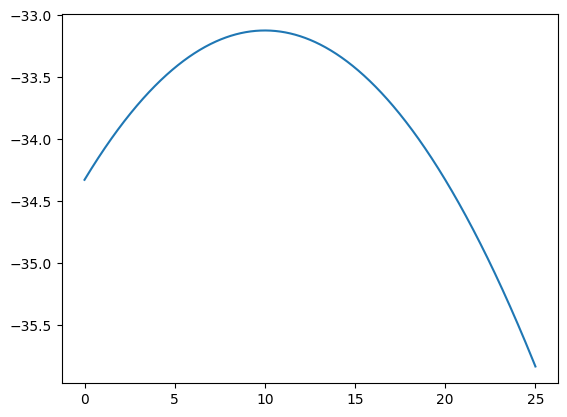

In [25]:
grad_Z,  grad_a = grad_logpriori(Z,0.1)
lr = 10
print(logpriori(Z,0.1))
print(logpriori(Z +lr*grad_Z,0.1+lr*grad_a))
plt.plot(np.linspace(0.0,25.0,1000),[logpriori(Z +lr*grad_Z,0.1+lr*grad_a) for lr in np.linspace(0.0,25.0,1000)])
plt.show()

## Potential energy

In [26]:
def U(Z,a,var=1):
    return (-1) * (loglikelihood(Z,a) + logpriori(Z,a,var))

def grad_U(Z,a,var=1):
    grad_Z_likelihood, grad_a_likelihood = grad_loglikelihood(Z,a)
    grad_Z_priori, grad_a_priori = grad_logpriori(Z,a,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    return -grad_Z, -grad_a

177.93271359584585
162.5017110802438


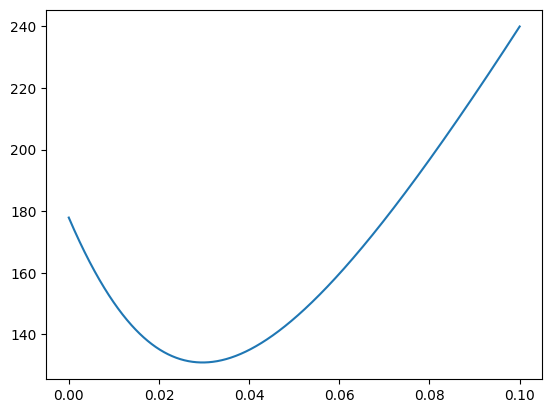

In [27]:
grad_Z,  grad_a = grad_U(Z,0.1)
lr = 0.005
print(U(Z,0.1))
print(U(Z - lr*grad_Z,0.1 - lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[U(Z -lr*grad_Z,0.1-lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [28]:
def compute_Z_star(Z, Z0):
    """ Computes Z* = Z0 Z^T (Z Z0^T Z0 Z^T)^(-1/2) Z using SVD """
    A = Z @ Z0.T @ Z0 @ Z.T  # Compute A = Z Z0^T Z0 Z^T
    
    # Compute A^(-1/2) using SVD
    U, S, _ = np.linalg.svd(A)
    S_inv_sqrt = np.diag(1.0 / np.sqrt(S))
    A_inv_sqrt = U @ S_inv_sqrt @ U.T
    Z_star =  Z0 @ Z.T @ A_inv_sqrt @ Z
    # Compute Z*
    return Z_star - np.mean(Z_star, axis=0)

In [29]:
def hmc(Z_init, a_init, num_samples, epsilon_init=0.05, std_dev=1.0, warmup=125):
    samples_Z = [Z_init]
    samples_a = [a_init]
    Hamiltonian_p = [U(Z_init,a_init)]

    acep_rate_history = np.zeros(num_samples)

    Z = Z_init.copy()
    a = a_init.copy()

    # Parámetros adaptativos
    epsilon = epsilon_init
    L = max(1, int(round(1/epsilon)))  # L = 1/ε
    accept_count = 0
    total_updates = 0

    
    for iter in tqdm(range(num_samples)):

        # Adaptación de parámetros
        adapting = iter < warmup
        if adapting and iter > 0 and iter % 3 == 0:
            # Ajustar epsilon basado en tasa de aceptación reciente
            current_accept_rate = accept_count / total_updates if total_updates > 0 else 0
            if current_accept_rate < 0.75:
                epsilon *= 0.95  # Reducir epsilon si aceptación es baja
            elif current_accept_rate > 0.85:
                epsilon *= 1.05  # Aumentar epsilon si aceptación es alta
            L = max(1, int(round(1/epsilon)))  # Actualizar L
            accept_count = 0
            total_updates = 0



        grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])


        ### HMC algorithm for Z

        for i in range(Z.shape[0]):
            grad_Z_i = grad_Z[i].copy()
            Z_i = Z[i].copy()
            
            p_i = np.random.normal(0, std_dev, size=Z_i.shape)
            current_p = p_i.copy()
            #Leapfrog integration
            p_i -= epsilon * grad_Z_i / 2        
            for _ in range(L):
                Z_i += epsilon * p_i
                Z[i] = Z_i
                grad_Z,  grad_a = grad_U(Z,samples_a[-1])
                grad_Z_i = grad_Z[i].copy()
                p_i -= epsilon * grad_Z_i
            p_i -= epsilon * grad_Z_i / 2
            p_i = -p_i  # Negate momentum to make the proposal symmetric
            # Hamiltonian
            current_U = U(samples_Z[-1],samples_a[-1])
            current_K = 0.5 * np.sum(current_p**2)
            current_H = current_U + current_K
            proposed_U = U(Z,samples_a[-1])
            proposed_K = 0.5 * np.sum(p_i**2)
            proposed_H = proposed_U + proposed_K
            # Metropolis-Hastings acceptance rate
            log_accept_ratio = current_H - proposed_H
            if log_accept_ratio > 0:
                Z_C = compute_Z_star(Z, Z0)
                samples_a.append(samples_a[-1])
                samples_Z.append(Z_C.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
            elif np.random.rand() < np.exp(log_accept_ratio):
                Z_C = compute_Z_star(Z, Z0)
                samples_a.append(samples_a[-1])
                samples_Z.append(Z_C.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
            else:
                samples_a.append(samples_a[-1])
                samples_Z.append(samples_Z[-1])
                Hamiltonian_p.append(current_H)
            total_updates += 1   

            grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])

        

        ### HMC algorithm for a
        grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])


        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p
            grad_Z,  grad_a = grad_U(samples_Z[-1],a)
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1])
        current_K = 0.5 * np.sum(current_p**2)
        current_H = current_U + current_K

        proposed_U = U(samples_Z[-1],a)
        proposed_K = 0.5 * np.sum(p**2)
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H
        if log_accept_ratio > 0:
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
        elif np.random.rand() < np.exp(log_accept_ratio):
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
        else:
            samples_a.append(samples_a[-1])
            samples_Z.append(samples_Z[-1])
            Hamiltonian_p.append(current_H)
        total_updates += 1    


        acep_rate_history[iter] = accept_count / total_updates if total_updates > 0 else 0

    aceptance_rate = accept_count / total_updates
    print(f"Acceptance rate: {aceptance_rate:.5f}")
    print(f"Final parameters: epsilon={epsilon:.4f}, L={L}")
    samples_Z = np.array(samples_Z)
    samples_a = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_a]
    Hamiltonian_p = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in Hamiltonian_p]
    return samples_Z, samples_a, Hamiltonian_p, acep_rate_history

## Results and visualization

In [30]:
Z1 = Z0 + np.random.randn(n, 2) * 1
a1 = a0 + np.random.randn() * 2

print(loglikelihood(Z1,a1))

-211.21263025486695


In [31]:
# Execute HMC
samples_Z, samples_a, Hp, acep_rate_history = hmc(Z1, a1, 2000, epsilon_init=0.05, std_dev=1.0, warmup=100)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [58:44<00:00,  1.76s/it] 

Acceptance rate: 0.83374
Final parameters: epsilon=0.0834, L=12


In [40]:
print("Loglikelihood of MAP estimator:")
print(loglikelihood(Z_MAP,a_MAP))
print("Loglikelihood of CM estimator:")
print(loglikelihood(Z_CM,a_CM))

Loglikelihood of MAP estimator:
-70.98159735942407
Loglikelihood of CM estimator:
-62.818566097649665


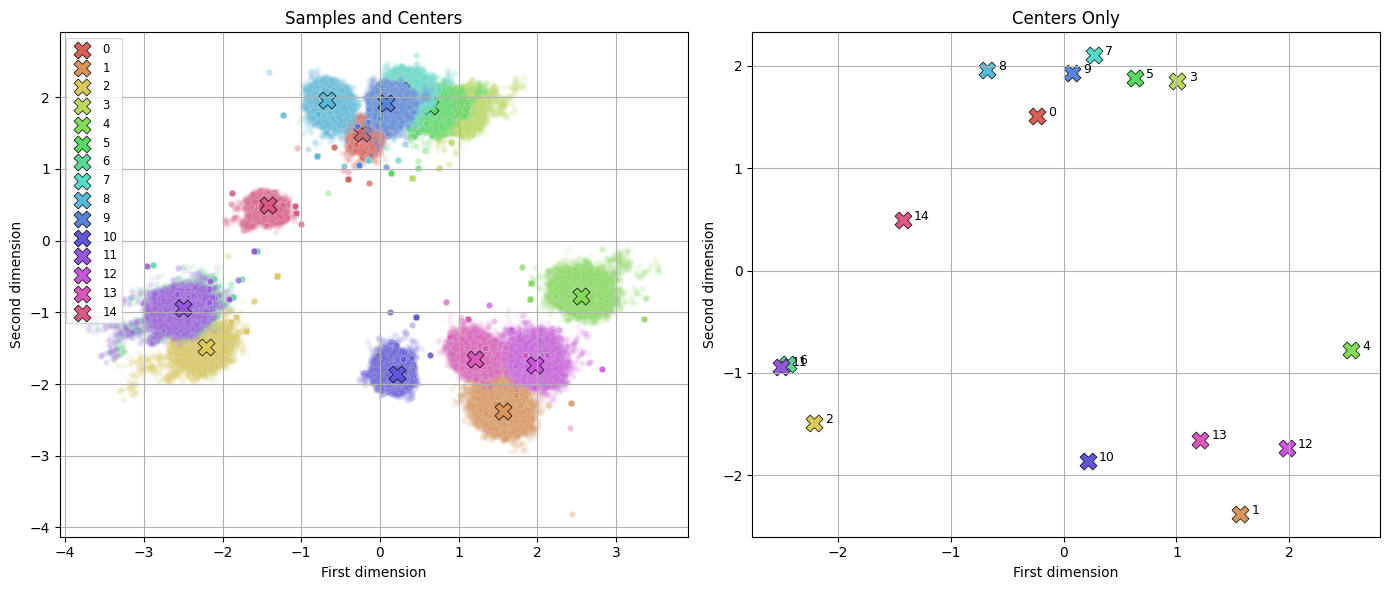

In [32]:
def plot_Z_samples(samples_Z):
    samples_Z = np.array(samples_Z)  
    num_points = samples_Z.shape[1]  
    palette = sns.color_palette("hls", num_points)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    centers = [] 

    for i in range(num_points):
        trace = samples_Z[:, i, :]
        mean_point = trace.mean(axis=0)
        centers.append(mean_point)
        sns.scatterplot(
            ax=axes[0],
            x=trace[:, 0],
            y=trace[:, 1],
            color=palette[i],
            alpha=0.1,
            s=20
        )

        sns.scatterplot(
            ax=axes[0],
            x=[mean_point[0]],
            y=[mean_point[1]],
            color=palette[i],
            marker='X',
            s=150,
            edgecolor='black',
            linewidth=0.5,
            label=f"{i}"
        )

        axes[1].scatter(
            mean_point[0],
            mean_point[1],
            color=palette[i],
            s=150,
            marker='X',
            edgecolor='black',
            linewidth=0.5
        )
        axes[1].text(
            mean_point[0] + 0.1,
            mean_point[1] + 0.001,
            f"{i}",
            fontsize=9
        )

    axes[0].set_title("Samples and Centers")
    axes[0].set_xlabel("First dimension")
    axes[0].set_ylabel("Second dimension")
    axes[0].legend(loc="best", fontsize="small")
    axes[0].grid(True)

    axes[1].set_title("Centers Only")
    axes[1].set_xlabel("First dimension")
    axes[1].set_ylabel("Second dimension")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_Z_samples(samples_Z)

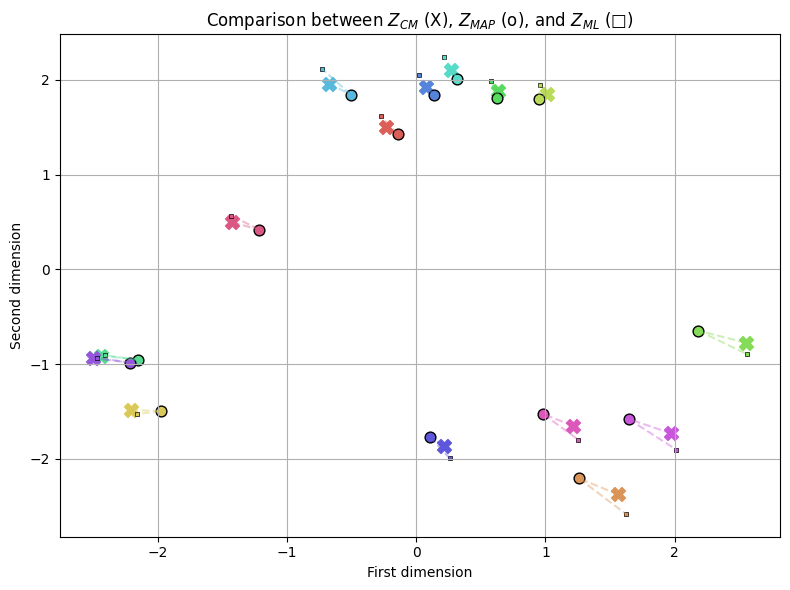

In [33]:
palette = sns.color_palette("hls", n)
plt.figure(figsize=(8, 6))
for i in range(n):
    x_cm, y_cm = Z_CM[i]
    x_map, y_map = Z_MAP[i]
    x_ml, y_ml = Z0[i]
    plt.scatter(x_cm, y_cm, color=palette[i], marker='X', s=100, label=f"{i+1} (CM)")
    plt.scatter(x_map, y_map, color=palette[i], marker='o', s=60, edgecolor='black', label=f"{i+1} (MAP)")
    plt.scatter(x_ml, y_ml, color=palette[i], marker='s', s=10, edgecolor='black', linewidth=0.5, label=f"{i+1} (ML)")

    plt.plot([x_cm, x_map], [y_cm, y_map], color=palette[i], linestyle='--', alpha=0.4)
    plt.plot([x_map, x_ml], [y_map, y_ml], color=palette[i], linestyle='--', alpha=0.4)
plt.xlabel("First dimension")
plt.ylabel("Second dimension")
plt.title("Comparison between $Z_{CM}$ (X), $Z_{MAP}$ (o), and $Z_{ML}$ (□)")
plt.grid(True)
plt.tight_layout()
plt.show()

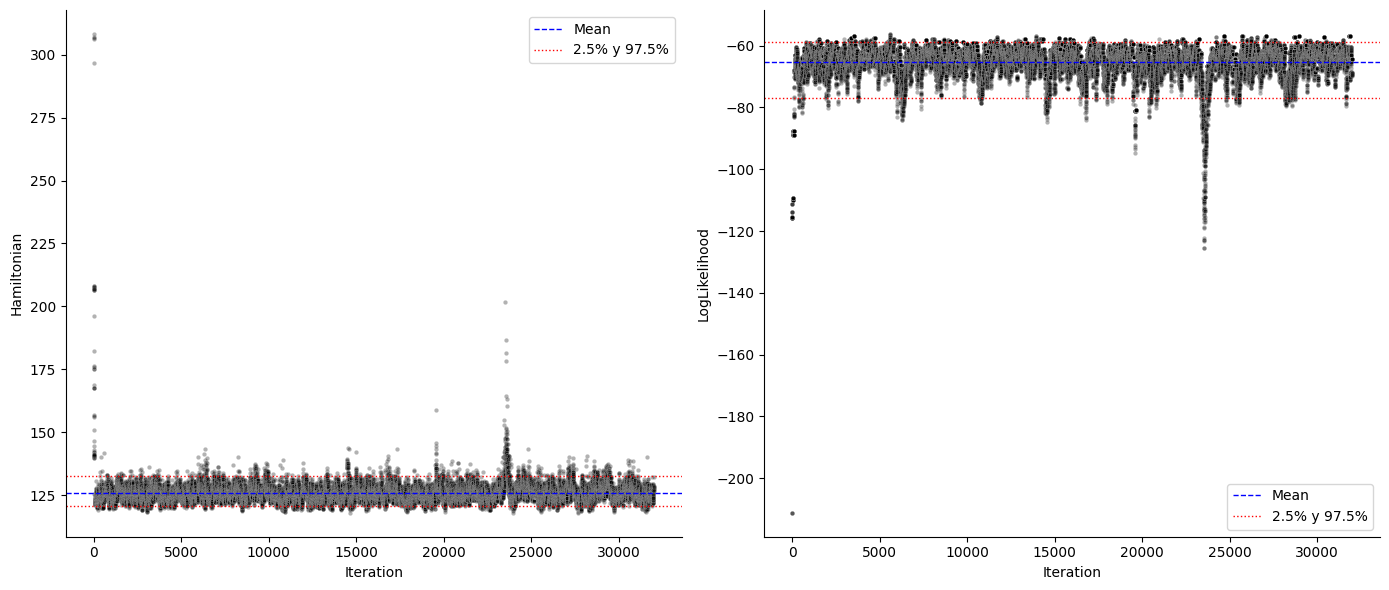

In [35]:
# 
x1 = Hp
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({
    'Iteration': iterations1,
    'LogLikelihood': x1
})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

# 
x2 = [np.float64(loglikelihood(samples_Z[i],samples_a[i]))for i in range(1,len(samples_a))]
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({
    'Iteration': iterations2,
    'LogLikelihood': x2
})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

#
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

# 
sns.scatterplot(ax=axs[0], x='Iteration', y='LogLikelihood', data=data1, color='black', alpha=0.3, s=10)
axs[0].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[0].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[0].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Hamiltonian")
axs[0].legend()


#
sns.scatterplot(ax=axs[1], x='Iteration', y='LogLikelihood', data=data2, color='black', alpha=0.3, s=10)
axs[1].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("LogLikelihood")
axs[1].legend()

sns.despine()
plt.tight_layout()
plt.show()


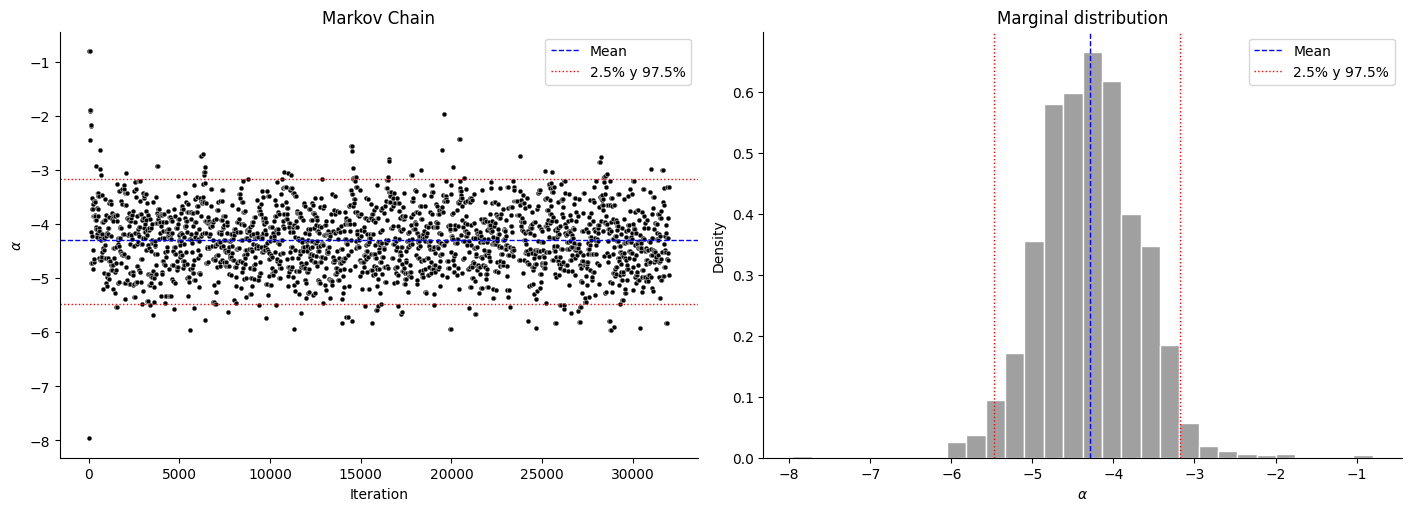

In [36]:
#
x = samples_a
#
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()

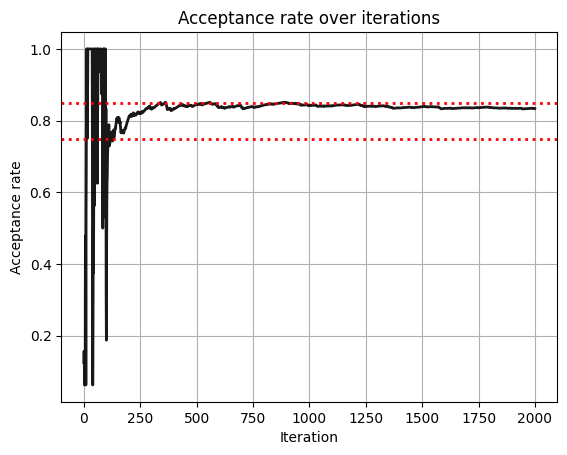

In [37]:
plt.plot(acep_rate_history, color='black', alpha=0.9, linewidth=2)
plt.axhline(0.85, color='red', linestyle=':', linewidth=2, label='')
plt.axhline(0.75, color='red', linestyle=':', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Acceptance rate")
plt.title("Acceptance rate over iterations")
plt.grid(True)
plt.show()

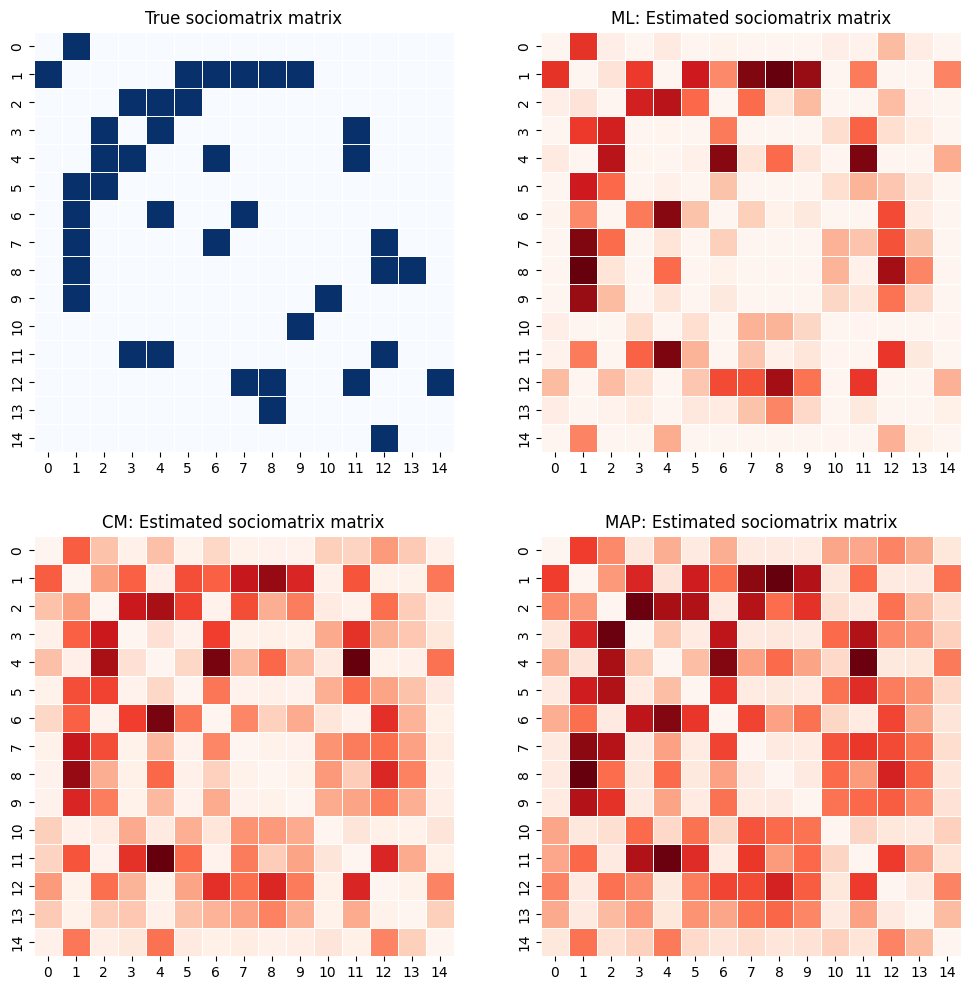

In [38]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM[i,j] = expit(a_CM * (1 - 0.05 * np.linalg.norm(Z_CM[i] - Z_CM[j])**2))

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP[i,j] = expit(a_MAP * (1 - 0.05 * np.linalg.norm(Z_MAP[i] - Z_MAP[j])**2))

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

# Post proccessing

In [ ]:
#pip install scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\carlo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
rang = np.arange(10000,len(samples_a),1)

samples_Z_pp = samples_Z[rang,:,:]
samples_a_pp = samples_a[10000:]
Hamiltonian_p_pp = Hp[10000:]
LL_pp = [np.float64(loglikelihood(samples_Z[i],samples_a[i]))for i in rang]
# Estimators
## CM
Z_CM_pp =  np.mean(samples_Z_pp, axis=0)
a_CM_pp = np.mean(samples_a_pp, axis=0)
## MAP

Z_MAP_pp = samples_Z[np.argmax(LL_pp ),:,:]
a_MAP_pp = samples_a[np.argmax(LL_pp )]

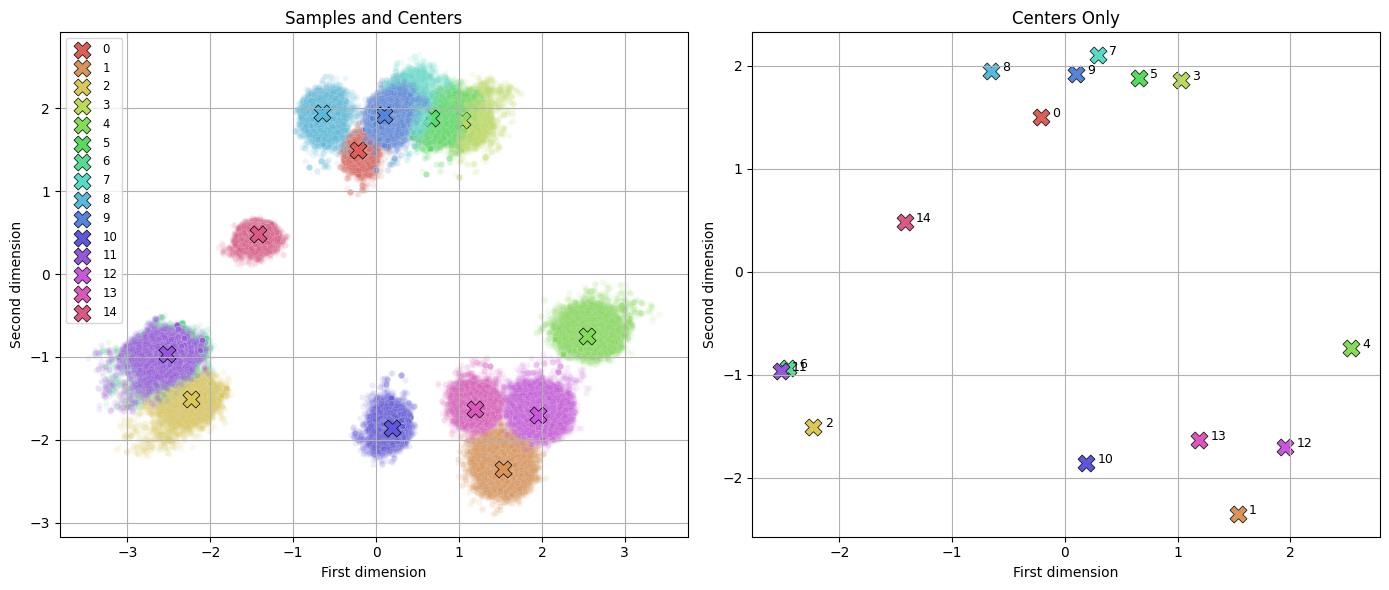

In [ ]:
plot_Z_samples(samples_Z_pp)

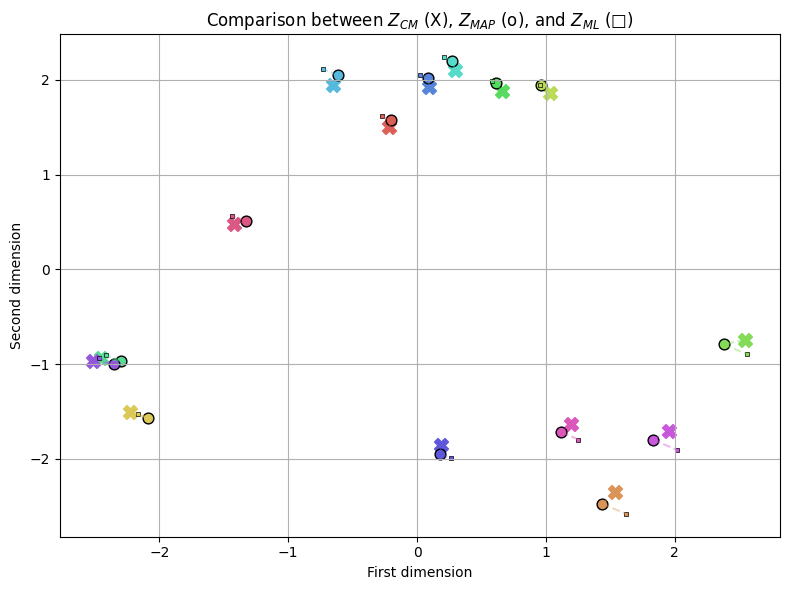

In [ ]:
palette = sns.color_palette("hls", n)
plt.figure(figsize=(8, 6))
for i in range(n):
    x_cm, y_cm = Z_CM_pp[i]
    x_map, y_map = Z_MAP_pp[i]
    x_ml, y_ml = Z0[i]
    plt.scatter(x_cm, y_cm, color=palette[i], marker='X', s=100, label=f"{i+1} (CM)")
    plt.scatter(x_map, y_map, color=palette[i], marker='o', s=60, edgecolor='black', label=f"{i+1} (MAP)")
    plt.scatter(x_ml, y_ml, color=palette[i], marker='s', s=10, edgecolor='black', linewidth=0.5, label=f"{i+1} (ML)")

    plt.plot([x_cm, x_map], [y_cm, y_map], color=palette[i], linestyle='--', alpha=0.4)
    plt.plot([x_map, x_ml], [y_map, y_ml], color=palette[i], linestyle='--', alpha=0.4)
plt.xlabel("First dimension")
plt.ylabel("Second dimension")
plt.title(r"Comparison between $Z_{CM}$ (X), $Z_{MAP}$ (o), and $Z_{ML}$ (□)")
plt.grid(True)
plt.tight_layout()
plt.show()

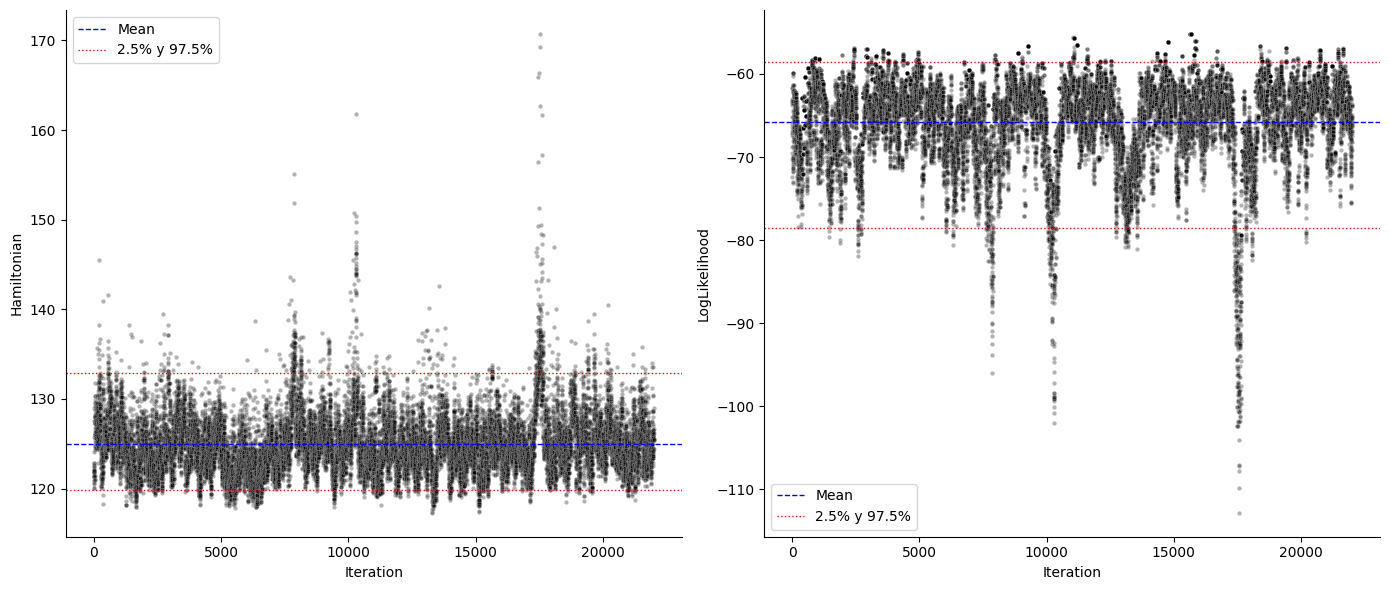

In [ ]:
# 
x1 = Hamiltonian_p_pp
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({
    'Iteration': iterations1,
    'LogLikelihood': x1
})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

# 
x2 = LL_pp
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({
    'Iteration': iterations2,
    'LogLikelihood': x2
})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

#
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

# 
sns.scatterplot(ax=axs[0], x='Iteration', y='LogLikelihood', data=data1, color='black', alpha=0.3, s=10)
axs[0].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[0].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[0].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Hamiltonian")
axs[0].legend()


#
sns.scatterplot(ax=axs[1], x='Iteration', y='LogLikelihood', data=data2, color='black', alpha=0.3, s=10)
axs[1].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("LogLikelihood")
axs[1].legend()

sns.despine()
plt.tight_layout()
plt.show()


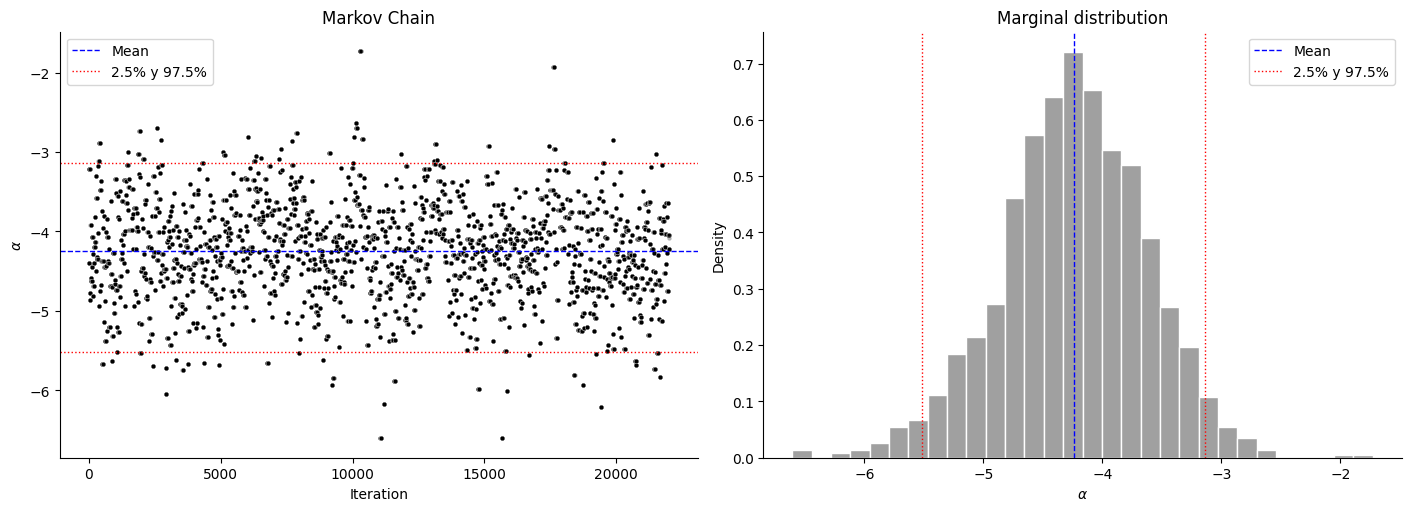

In [ ]:
x = samples_a_pp
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()

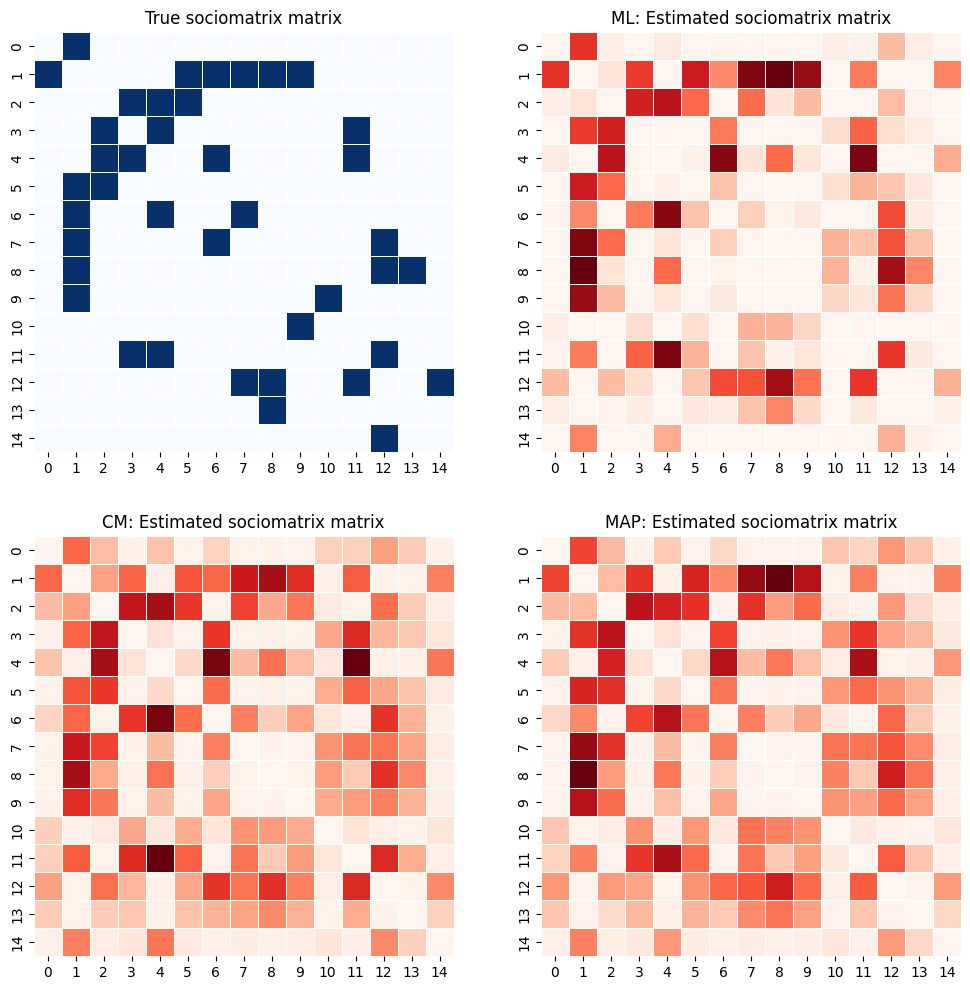

In [ ]:
Y_CM_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM_pp[i,j] = expit(a_CM_pp * (1 - 0.05 * np.linalg.norm(Z_CM_pp[i] - Z_CM_pp[j])**2))

Y_MAP_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP_pp[i,j] = expit(a_MAP_pp * (1 - 0.05 * np.linalg.norm(Z_MAP_pp[i] - Z_MAP_pp[j])**2))

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM_pp, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP_pp, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

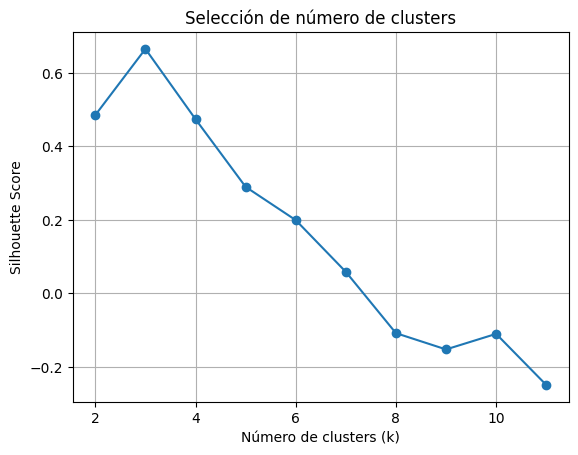

Mejor número de clusters según Silhouette Score: 3


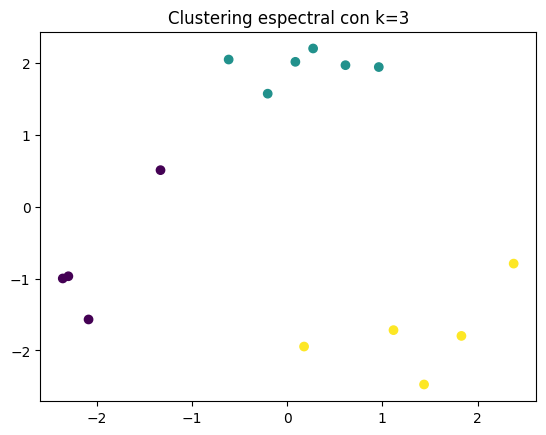

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Definir el rango de clusters que quieres probar
cluster_range = range(2, 12)
silhouette_scores = []

# Buscar el mejor número de clusters
for k in cluster_range:
    sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
    labels = sc.fit_predict(Z_MAP_pp)
    score = silhouette_score(Z_MAP_pp, labels)
    silhouette_scores.append(score)

# Graficar Silhouette Score vs número de clusters
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Selección de número de clusters")
plt.grid(True)
plt.show()

# Seleccionar el mejor número de clusters
best_k = cluster_range[np.argmax(silhouette_scores)]
print(f"Mejor número de clusters según Silhouette Score: {best_k}")

# Hacer el clustering final con el mejor número de clusters
sc = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
labels = sc.fit_predict(Z_MAP_pp)

# Visualizar el resultado
plt.scatter(Z_MAP_pp[:, 0], Z_MAP_pp[:, 1], c=labels, cmap='viridis')
plt.title(f"Clustering espectral con k={best_k}")
plt.show()

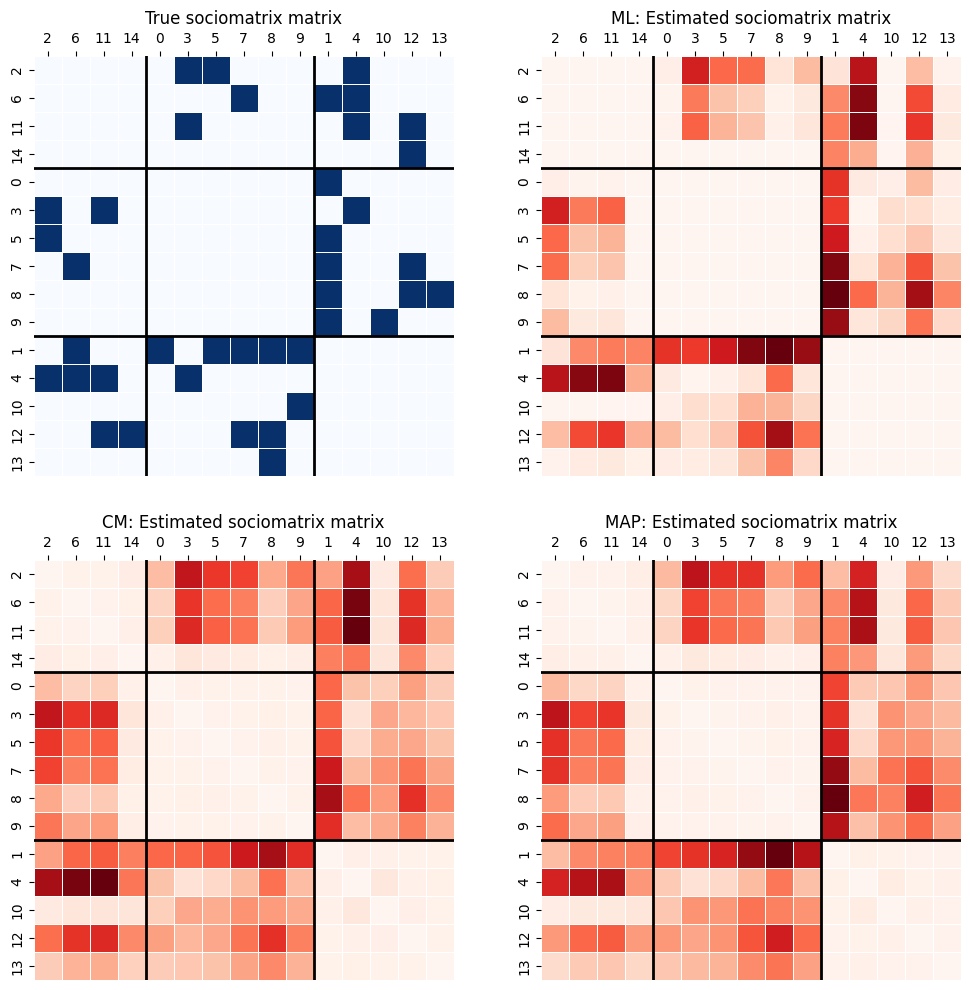

In [ ]:
boundaries = []
for i in range(1, len(np.sort(labels))):
    if np.sort(labels)[i] != np.sort(labels)[i-1]:
        boundaries.append(i)

Y_CM_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM_pp[i,j] = expit(a_CM_pp * (1 - 0.05 * np.linalg.norm(Z_CM_pp[i] - Z_CM_pp[j])**2))

Y_CM_pp_sorted = Y_CM_pp[np.argsort(labels), :][:, np.argsort(labels)]

Y_MAP_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP_pp[i,j] = expit(a_MAP_pp * (1 - 0.05 * np.linalg.norm(Z_MAP_pp[i] - Z_MAP_pp[j])**2))


Y_MAP_pp_sorted = Y_MAP_pp[np.argsort(labels), :][:, np.argsort(labels)]

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
ax1 = sns.heatmap(nx.to_numpy_array(G, dtype=int)[np.argsort(labels), :][:, np.argsort(labels)], annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
for boundary in boundaries:
    ax1.axhline(boundary, color='black', linewidth=2)
    ax1.axvline(boundary, color='black', linewidth=2)

plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
ax2 = sns.heatmap(Y[np.argsort(labels), :][:, np.argsort(labels)], annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
for boundary in boundaries:
    ax2.axhline(boundary, color='black', linewidth=2)
    ax2.axvline(boundary, color='black', linewidth=2)
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
ax3 = sns.heatmap(Y_CM_pp_sorted, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax3.xaxis.set_ticks_position('top')
ax3.xaxis.set_label_position('top')
for boundary in boundaries:
    ax3.axhline(boundary, color='black', linewidth=2)
    ax3.axvline(boundary, color='black', linewidth=2)
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
ax4 = sns.heatmap(Y_MAP_pp_sorted, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax4.xaxis.set_ticks_position('top')
ax4.xaxis.set_label_position('top')
for boundary in boundaries:
    ax4.axhline(boundary, color='black', linewidth=2)
    ax4.axvline(boundary, color='black', linewidth=2)
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

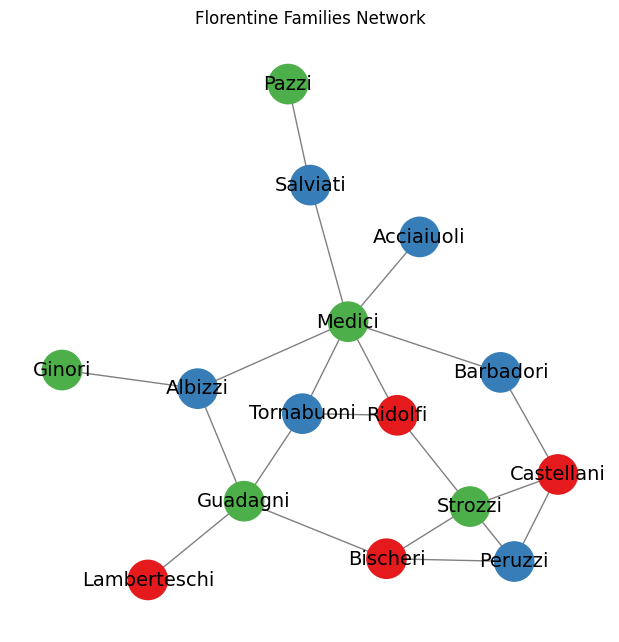

In [ ]:
plt.figure(figsize=(6,6))
cmap = plt.colormaps.get_cmap('Set1')
nx.draw(G, nx.spring_layout(G, seed=4),with_labels=False, node_color=[cmap(label) for label in labels], edge_color='gray', node_size=800)
node_mapping_inv = {v: k for k, v in node_mapping.items()}
nx.draw_networkx_labels(G, nx.spring_layout(G, seed=4), labels=node_mapping_inv, font_size=14, font_color='black')
plt.title("Florentine Families Network")
plt.show()

## References

[1] Hoff, P. D., Raftery, A. E., & Handcock, M. S. (2002). Latent space approaches to social network analysis. Journal of the American Statistical Association, 97(460), 1090-1098. https://doi.org/10.1198/016214502388618906